In [3]:
%matplotlib inline
from config_calc import *

import matplotlib
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'

import cmocean
import plot_tools

import scipy.io as sio

In [180]:
matdata = sio.loadmat('data/global_o2_trend.mat',squeeze_me=True)
for k in matdata.keys():
    if '__' in k: continue
    print k
    print matdata[k].shape
    print

Neff
(5, 3)

oxy_trend_gm
(5, 3)

o2gm
(5, 40, 3)

t1
(40,)

r2_gm
(5, 3)

tval95_gm
(5, 3)

stderr_trend_gm
(5, 3)



In [181]:
depth = xr.DataArray(np.array([100.,200.,400.,700.,1000.]),dims=('depth'),
                    coords={'depth':np.array([100.,200.,400.,700.,1000.])})

basin = xr.DataArray(np.array(['Global','Pacific','Atlantic']),dims=('basin'),
                    coords={'basin':np.array(['Global','Pacific','Atlantic'])})

time = xr.DataArray(matdata['t1'],dims=('time'),coords={'time':matdata['t1']})

obs_trend = xr.DataArray(matdata['o2gm'],dims=('depth','time','basin'),
                     coords={'depth':depth,'time':time,'basin':basin})

oxy_trend_gm = xr.DataArray(matdata['oxy_trend_gm'],dims=('depth','basin'))
oxy_trend_stderr = xr.DataArray(matdata['stderr_trend_gm'],dims=('depth','basin'))

obs = xr.Dataset({'o2':obs_trend,'trend_mean':oxy_trend_gm,
                  'trend_err':oxy_trend_stderr})
print obs

<xarray.Dataset>
Dimensions:     (basin: 3, depth: 5, time: 40)
Coordinates:
  * depth       (depth) float64 100.0 200.0 400.0 700.0 1e+03
  * basin       (basin) object 'Global' 'Pacific' 'Atlantic'
  * time        (time) float64 1.97e+03 1.971e+03 1.972e+03 1.973e+03 ...
Data variables:
    trend_mean  (depth, basin) float64 -0.1335 -0.126 -0.1783 -0.1685 ...
    trend_err   (depth, basin) float64 0.05599 0.04757 0.07855 0.08676 ...
    o2          (depth, time, basin) float64 2.249 4.301 -0.6601 0.9426 ...


In [182]:
pentads = np.arange(1970,2015,5)
obs5 = obs.groupby_bins('time',pentads).mean(dim='time')
obs5['o2_std'] = obs.o2.groupby_bins('time',pentads).std(dim='time')
obs5['time'] = np.vstack((pentads[:-1],pentads[1:])).mean(axis=0)
obs5['trend_mean'] = obs.trend_mean
obs5['trend_err'] = obs.trend_err
obs5

<xarray.Dataset>
Dimensions:     (basin: 3, depth: 5, time: 8, time_bins: 8)
Coordinates:
  * time_bins   (time_bins) object (1970, 1975] (1975, 1980] (1980, 1985] ...
  * depth       (depth) float64 100.0 200.0 400.0 700.0 1e+03
  * basin       (basin) object 'Global' 'Pacific' 'Atlantic'
  * time        (time) float64 1.972e+03 1.978e+03 1.982e+03 1.988e+03 ...
Data variables:
    trend_mean  (depth, basin) float64 -0.1335 -0.126 -0.1783 -0.1685 ...
    trend_err   (depth, basin) float64 0.05599 0.04757 0.07855 0.08676 ...
    o2          (time_bins, depth, basin) float64 1.537 2.016 1.231 1.701 ...
    o2_std      (depth, time_bins, basin) float64 0.4653 1.314 1.091 0.5928 ...

In [81]:
matdata = sio.loadmat('data/o2trend_le.mat')
for k in matdata.keys():
    if '__' in k: continue
    print k
    print matdata[k].shape
    print

stderr_trend_le
(5, 3, 34)

stderr_trend_lex
(180, 5, 3, 34)

oxy_trend_lex
(180, 5, 3, 34)

tval95_lex
(180, 5, 3, 34)

r2_le
(5, 3, 34)

tval95_le
(5, 3, 34)

r2_lex
(180, 5, 3, 34)

o2le
(5, 40, 3, 34)

oxy_trend_le
(5, 3, 34)

o2lex
(180, 5, 40, 3, 34)



In [86]:
o2 = xr.DataArray(matdata['o2le'],dims=('depth','time','basin','ens'),
                          coords={'depth':depth,'time':time,'basin':basin})

trend_mean = xr.DataArray(matdata['oxy_trend_le'],dims=('depth','basin','ens'),
                         coords={'depth':depth,'basin':basin})

cesm_le = xr.Dataset({'o2':o2,'trend_mean':trend_mean})
cesm_le

<xarray.Dataset>
Dimensions:     (basin: 3, depth: 5, ens: 34, time: 40)
Coordinates:
  * depth       (depth) float64 100.0 200.0 400.0 700.0 1e+03
  * basin       (basin) |S8 'Global' 'Pacific' 'Atlantic'
  * time        (time) float64 1.97e+03 1.971e+03 1.972e+03 1.973e+03 ...
Dimensions without coordinates: ens
Data variables:
    trend_mean  (depth, basin, ens) float64 -0.06076 -0.05048 -0.06967 ...
    o2          (depth, time, basin, ens) float64 221.5 220.2 221.2 221.4 ...

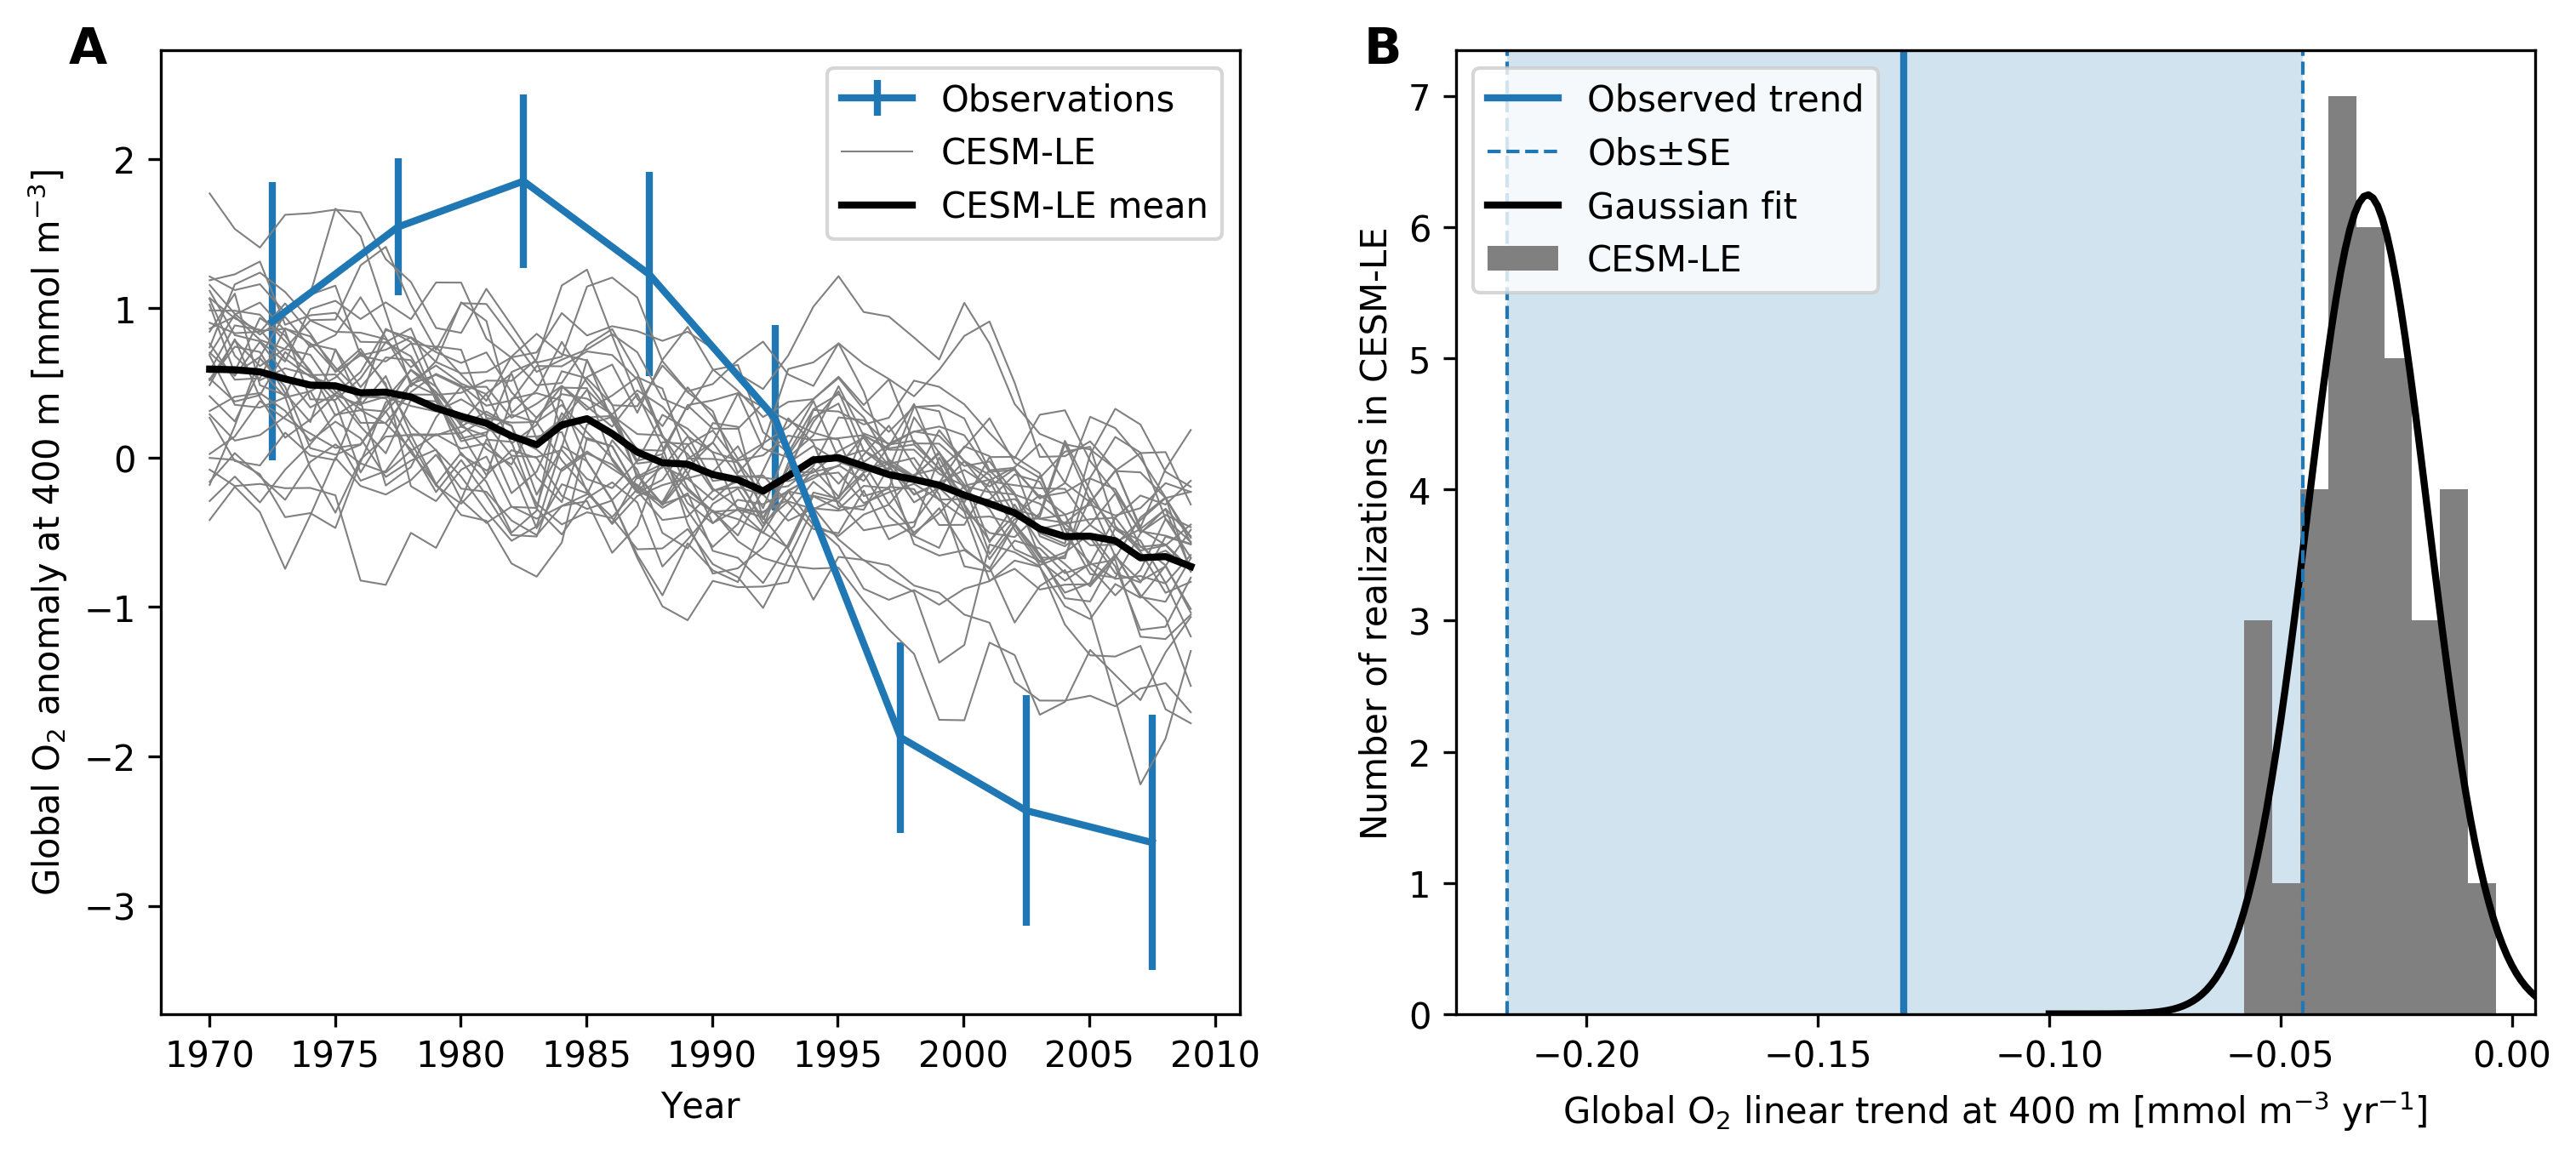

In [183]:
plot_name = os.path.join(diro['fig'],'obs-cesm-global-trends.pdf')

fig = plt.figure(dpi=300,figsize=(12,5),facecolor='w')
gs = gridspec.GridSpec(1,2)


obsplot = obs5.sel(basin='Global',depth=400)
cesmplot = cesm_le.sel(basin='Global',depth=400)
cesmplota = cesmplot.mean(dim='ens')


ax = fig.add_subplot(gs[0,0])
po = ax.errorbar(obsplot.time,obsplot.o2, yerr=obsplot.o2_std,linewidth=2,
           label = 'Observations')

pe = ax.plot(cesmplot.time,cesmplot.o2-cesmplota.o2.mean(),color='gray',linewidth=0.5,
       label='CESM-LE')
pa = ax.plot(cesmplot.time,cesmplota.o2-cesmplota.o2.mean(),color='k',linewidth=2,
       label='CESM-LE mean')

ax.legend([po,pe[0],pa[0]],['Observations','CESM-LE','CESM-LE mean'])

ax.set_ylabel('Global O$_2$ anomaly at 400 m [mmol m$^{-3}$]')
ax.set_xlabel('Year')


ax = fig.add_subplot(gs[0,1])

n,bins,ph = ax.hist(cesmplot.trend_mean,9,color='gray')

b = np.diff(bins)[0]
x = np.arange(-0.1,0.005,0.001)
s = cesmplot.trend_mean.std().values
m = cesmplot.trend_mean.mean().values

y = b * 34. / (s * np.sqrt(2.*np.pi)) * np.exp(-0.5*((x-m)/s)**2)

pg = ax.plot(x,y,color='k',linewidth=2.)

ylim = ax.get_ylim()


x = np.arange(obsplot.trend_mean-obsplot.trend_err,
              obsplot.trend_mean+obsplot.trend_err+0.001,0.001)
ax.fill_between(x,ylim[0],ylim[1],alpha=0.2)
po = ax.axvline(obsplot.trend_mean,linewidth=2.)

ps = ax.axvline(x[0],linestyle='--',linewidth=1)
ax.axvline(x[-1],linestyle='--',linewidth=1)
xlim = ax.get_xlim()

ax.set_xlim((xlim[0],0.005))
ax.set_ylim(ylim)

ax.set_ylabel('Number of realizations in CESM-LE')
ax.set_xlabel('Global O$_2$ linear trend at 400 m [mmol m$^{-3}$ yr$^{-1}$]')

ax.legend([po,ps,pg[0],ph[0]],['Observed trend','Obs$\pm$SE','Gaussian fit','CESM-LE'])

alp = [chr(i).upper() for i in range(97,97+26)]

for i,axi in enumerate(fig.get_axes()):
    p = axi.get_position()
    y = p.y1-0.01
    x = p.x0-0.03
    fig.text(x,y,'%s'%alp[i],
             fontsize=14.,
             fontweight = 'semibold')
    
plt.savefig(plot_name,bbox_inches='tight')

R2le
(1, 34)

suff
(1, 34)

SEcore
(1, 1)

TRcore
(1, 1)

trend1core
(360, 180)

TRobs
(1, 1)

trend1obs
(360, 180)

STNAo2obs
(40, 1)

trend1le
(360, 180, 34)

SEle
(1, 34)

STNAo2le
(40, 34)

tval95le
(1, 34)

tval95obs
(1, 1)

TRle
(1, 34)

R2obs
(1, 1)

R2core
(1, 1)

STNAo2core
(40, 1)

SEobs
(1, 1)

tval95core
(1, 1)



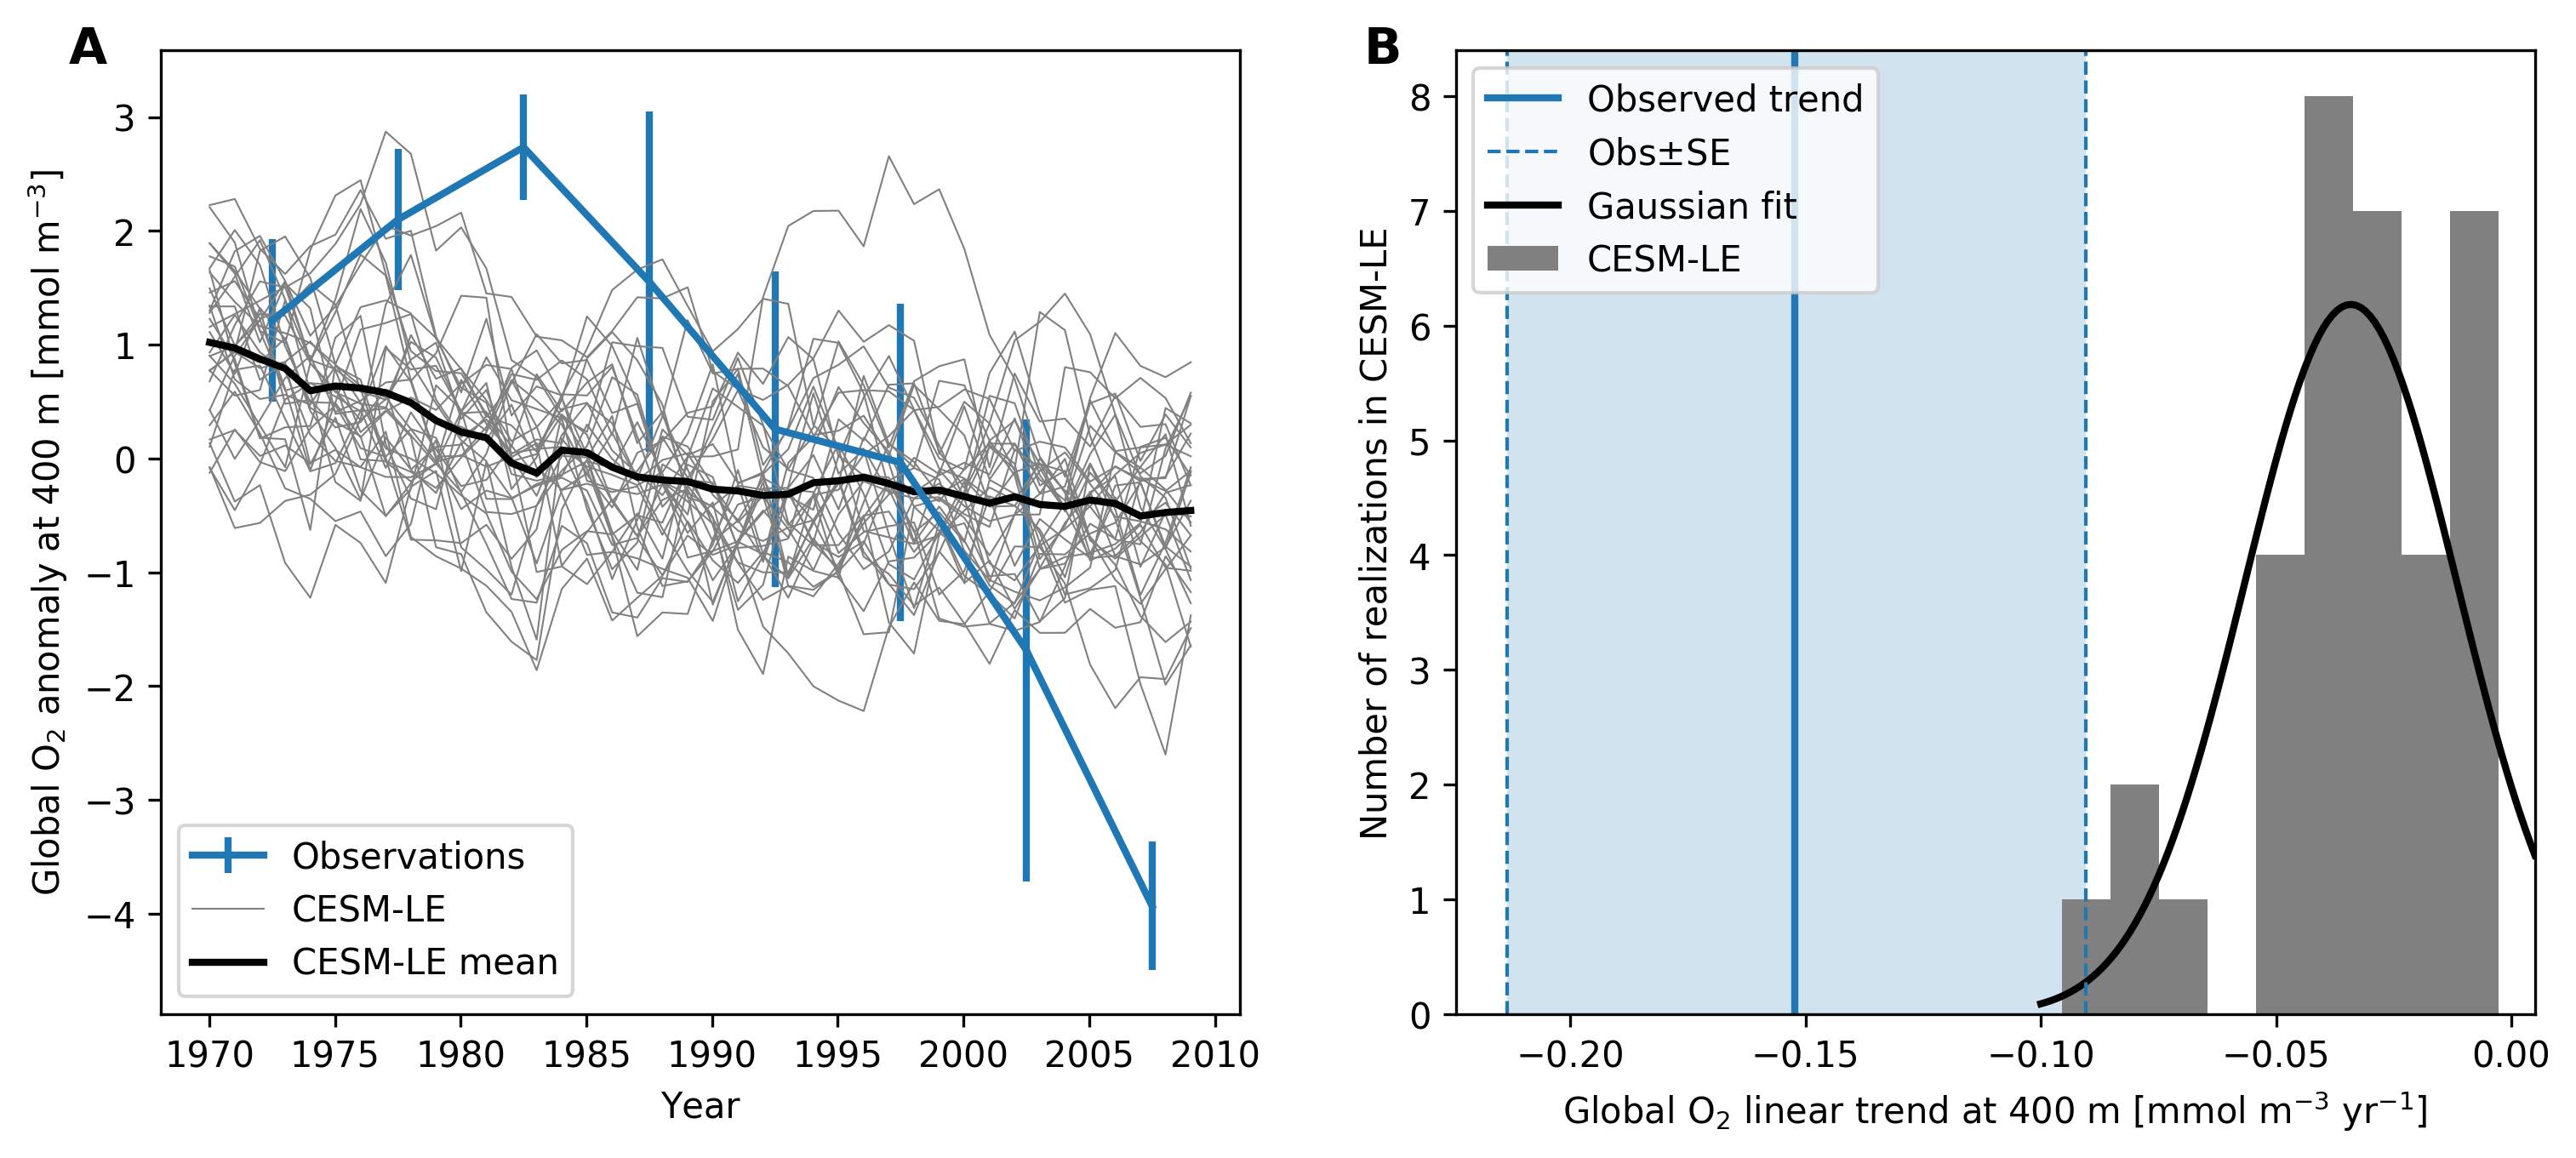

In [178]:
plot_name = os.path.join(diro['fig'],'obs-cesm-global-trends.pdf')

fig = plt.figure(dpi=300,figsize=(12,5),facecolor='w')
gs = gridspec.GridSpec(1,2)


obsplot = obs5.sel(basin='Atlantic',depth=400)
cesmplot = cesm_le.sel(basin='Atlantic',depth=400)
cesmplota = cesmplot.mean(dim='ens')


ax = fig.add_subplot(gs[0,0])
po = ax.errorbar(obsplot.time,obsplot.trend, yerr=obsplot.tr_std,linewidth=2,
           label = 'Observations')

pe = ax.plot(cesmplot.time,cesmplot.o2-cesmplota.o2.mean(),color='gray',linewidth=0.5,
       label='CESM-LE')
pa = ax.plot(cesmplot.time,cesmplota.o2-cesmplota.o2.mean(),color='k',linewidth=2,
       label='CESM-LE mean')

ax.legend([po,pe[0],pa[0]],['Observations','CESM-LE','CESM-LE mean'])

ax.set_ylabel('Global O$_2$ anomaly at 400 m [mmol m$^{-3}$]')
ax.set_xlabel('Year')


ax = fig.add_subplot(gs[0,1])

n,bins,ph = ax.hist(cesmplot.trend_mean,9,color='gray')

b = np.diff(bins)[0]
x = np.arange(-0.1,0.005,0.001)
s = cesmplot.trend_mean.std().values
m = cesmplot.trend_mean.mean().values

y = b * 34. / (s * np.sqrt(2.*np.pi)) * np.exp(-0.5*((x-m)/s)**2)

pg = ax.plot(x,y,color='k',linewidth=2.)

ylim = ax.get_ylim()


x = np.arange(obsplot.trend_mean-obsplot.trend_err,
              obsplot.trend_mean+obsplot.trend_err+0.001,0.001)
ax.fill_between(x,ylim[0],ylim[1],alpha=0.2)
po = ax.axvline(obsplot.trend_mean,linewidth=2.)

ps = ax.axvline(x[0],linestyle='--',linewidth=1)
ax.axvline(x[-1],linestyle='--',linewidth=1)
xlim = ax.get_xlim()

ax.set_xlim((xlim[0],0.005))
ax.set_ylim(ylim)

ax.set_ylabel('Number of realizations in CESM-LE')
ax.set_xlabel('Global O$_2$ linear trend at 400 m [mmol m$^{-3}$ yr$^{-1}$]')

ax.legend([po,ps,pg[0],ph[0]],['Observed trend','Obs$\pm$SE','Gaussian fit','CESM-LE'])

alp = [chr(i).upper() for i in range(97,97+26)]

for i,axi in enumerate(fig.get_axes()):
    p = axi.get_position()
    y = p.y1-0.01
    x = p.x0-0.03
    fig.text(x,y,'%s'%alp[i],
             fontsize=14.,
             fontweight = 'semibold')